In [12]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [13]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)

Device: cuda 11 / 20 / 2020


In [14]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
# testloader = DataLoader()

In [15]:
trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
train_set = torch.from_numpy(ecg_clean)

In [16]:
train_set = train_set[0:10]
train_set = train_set.view(train_set.shape[0], 1024, 1)
train_set.shape

torch.Size([10, 1024, 1])

In [17]:
# kernel_size = 16
# padding_size= int( kernel_size/2 ) # If odd, add -1

# class ae_sampler(nn.Module):
#     def __init__(self):
#         super(ae_sampler, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
#             # nn.Conv1d(40, 20, kernel_size, stride=2, padding=padding_size)
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(40, 1024, 1, stride=2)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)

#         return x

In [18]:
def train_model( model, train_set, lr, epochs):
    lr = 1e-3 if None else lr
    criterion = nn.MSELoss( size_average=False )
    optimizer = torch.optim.Adam( model.parameters() )

    mean_losses = []
    # Iterate for each epoch
    for epoch in range( epochs ):
        model.train()
        losses = []
        # Iterate the entire data set
        for i in train_set:
            i = i.view( 1, i.shape[0], i.shape[1] )

            optimizer.zero_grad()
            x_prime = model(i)
            loss = criterion(x_prime, i)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)
        print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses

In [19]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1024, 1, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [20]:
model = ae_sampler()
model.double()
losses = train_model( model, train_set, None, epochs=15)

Epoch: 0, Loss: 0.8141212276387423
Epoch: 1, Loss: 0.548683970472247
Epoch: 2, Loss: 0.4109115600754732
Epoch: 3, Loss: 0.3478356097249065
Epoch: 4, Loss: 0.31327563800862535
Epoch: 5, Loss: 0.2721223433407489
Epoch: 6, Loss: 0.22942252410270447
Epoch: 7, Loss: 0.18804137552891895
Epoch: 8, Loss: 0.1505989156437695
Epoch: 9, Loss: 0.11800180517796846
Epoch: 10, Loss: 0.08926100091870669
Epoch: 11, Loss: 0.06470559547619646
Epoch: 12, Loss: 0.04471543536903807
Epoch: 13, Loss: 0.03001613185631732
Epoch: 14, Loss: 0.02013973699676249


In [21]:
x = model.encoder(train_set)
x = model.decoder(x)
x = x.detach().numpy()
print( x.shape )

(10, 1024, 1)


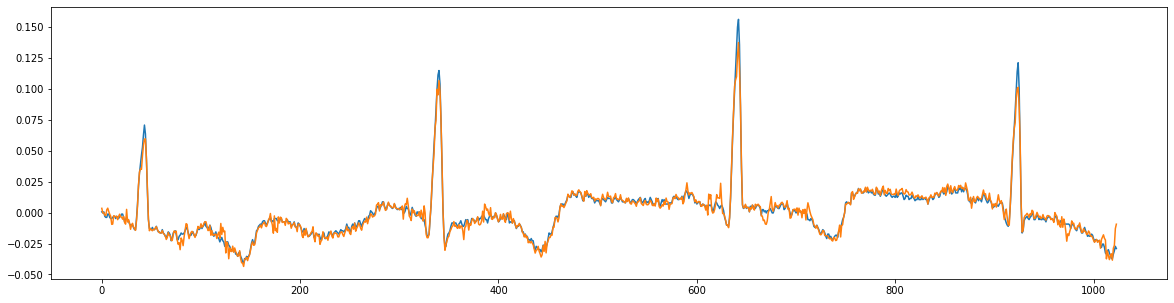

In [24]:
if x.shape[2] == 1:
    plt.figure(figsize=(20,5))
    plt.plot(train_set[0])
    plt.plot(x[0])
else:
    print("Shape is too large")

In [23]:
from torchsummary import summary
summary( model )

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              41,984
Total params: 697,384
Trainable params: 697,384
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              41,984
Total params: 697,384
Trainable params: 697,384
Non-trainable params: 0